RF to predict tti or log tti or ahd from all other data
 use households until find pop
dimensionality reduction?

factorsd impacting congestion, networks, tti, modeshares

tti website has other papers
modeshare variables
feature importance what is the direction of impact (negative vs. positive, impurity)
plot to show errors from rf optimization, 2d contour plot
rf/gbm as feature extractor
pca, condense and explain
kernel pca
update manuscript
final model (generalize additive model)
poster

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

In [3]:
#cfc = pd.read_csv('../../data/tidy/msa-carbon-footprint.csv')
trf = pd.read_csv('../../data/tidy/tti-renamed.csv')
net = pd.read_csv('../../data/tidy/data-aggregation-networkstats.csv')
inc = pd.read_csv('../../data/tidy/asc19-hh-income.csv')
mod = pd.read_csv('../../data/tidy/acs19-modeshares.csv')
unemp = pd.read_csv('../../data/tidy/acs19-unemp.csv')
#cfc = pd.read_csv('../../data/tidy/combined-dataset.csv')

In [4]:
#ahd_list = df['ahd'].tolist()
 
# show the list
#print(ahd_list)

In [5]:
#cfc = cfc.dropna(subset=['tti'])


In [6]:
trf

,msa,auto_commuters,annual_excess_fuel_consumed_commuters,ahd,tti
0,"Abilene, TX",62,788,1694,1.06
1,"Akron, OH",298,6453,14470,1.11
2,"Albany, GA",53,810,1752,1.07
3,"Albany-Schenectady-Troy, NY",300,5172,13605,1.14
4,"Albuquerque, NM",380,8950,18864,1.15
...,...,...,...,...,...
337,"Yakima, WA",76,1180,2522,1.09
338,"York-Hanover, PA",49,227,594,1.12
339,"Youngstown-Warren-Boardman, OH-PA",217,3121,7185,1.05
340,"Yuba City, CA",66,1081,2490,1.16


In [7]:
net

,msa,n,m,k_avg,edge_length_total,edge_length_avg,streets_per_node_avg,intersection_count,street_length_total,street_segment_count,street_length_avg,circuity_avg,self_loop_proportion,node_density_km,intersection_density_km,edge_density_km,street_density_km,builing_area_sqkm,area_sqkm
0,"Abilene, TX",14357,39401,5.488751,1.716897e+07,435.749497,2.881452,11912,8.925436e+06,20606,433.147439,1.067840,0.004465,2.012523,1.669790,2406.696840,1251.142264,7.048505,7133.829924
1,"Albany, GA",8466,22838,5.395228,9.545102e+06,417.948256,2.837468,6957,4.989593e+06,11954,417.399446,1.052833,0.002928,2.028965,1.667318,2287.583389,1195.808038,6.979580,4172.570196
2,"Akron, OH",26865,70900,5.278243,1.519199e+07,214.273426,2.756896,21200,8.039295e+06,36980,217.395754,1.056240,0.015089,11.231303,8.862967,6351.230011,3360.943838,14.307097,2391.975398
3,"Albany-Lebanon, OR",7132,17906,5.021312,8.280294e+06,462.431276,2.568144,5101,4.225439e+06,9147,461.948061,1.150205,0.005466,1.193324,0.853498,1385.456359,706.999160,7.519705,5976.582645
4,"Albany-Schenectady-Troy, NY",36977,96867,5.239311,2.787244e+07,287.739291,2.755794,30254,1.455542e+07,50900,285.961192,1.091565,0.033320,4.962653,4.060365,3740.737967,1953.471821,41.455466,7451.054339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,"Worcester, MA-CT",38037,95787,5.036517,2.460403e+07,256.861904,2.657938,29828,1.289468e+07,50471,255.486983,1.077187,0.017416,6.986970,5.479069,4519.484519,2368.608706,74.415961,5443.990594
368,"York-Hanover, PA",16622,44476,5.351462,1.329126e+07,298.841079,2.781194,13507,6.831205e+06,23064,296.184733,1.080534,0.006287,7.049714,5.728582,5637.080320,2897.246871,18.432839,2357.826232
369,"Yuba City, CA",8419,21665,5.146692,7.925868e+06,365.837452,2.678465,6360,4.094273e+06,11260,363.612188,1.084151,0.002220,2.597365,1.962138,2445.227397,1263.133400,1.594076,3241.362503
370,"Youngstown-Warren-Boardman, OH-PA",24885,66650,5.356641,1.973854e+07,296.152150,2.794736,19982,1.038162e+07,34674,299.406523,1.044778,0.006085,5.511548,4.425628,4371.706396,2299.329155,15.897550,4515.065516


In [8]:
df = trf.merge(net, left_on='msa', right_on='msa', how='left')

In [9]:
df.head()

,msa,auto_commuters,annual_excess_fuel_consumed_commuters,ahd,tti,n,m,k_avg,edge_length_total,edge_length_avg,...,street_segment_count,street_length_avg,circuity_avg,self_loop_proportion,node_density_km,intersection_density_km,edge_density_km,street_density_km,builing_area_sqkm,area_sqkm
0,"Abilene, TX",62,788,1694,1.06,14357,39401,5.488751,1.716897e+07,435.749497,...,20606,433.147439,1.067840,0.004465,2.012523,1.669790,2406.696840,1251.142264,7.048505,7133.829924
1,"Akron, OH",298,6453,14470,1.11,26865,70900,5.278243,1.519199e+07,214.273426,...,36980,217.395754,1.056240,0.015089,11.231303,8.862967,6351.230011,3360.943838,14.307097,2391.975398
2,"Albany, GA",53,810,1752,1.07,8466,22838,5.395228,9.545102e+06,417.948256,...,11954,417.399446,1.052833,0.002928,2.028965,1.667318,2287.583389,1195.808038,6.979580,4172.570196
3,"Albany-Schenectady-Troy, NY",300,5172,13605,1.14,36977,96867,5.239311,2.787244e+07,287.739291,...,50900,285.961192,1.091565,0.033320,4.962653,4.060365,3740.737967,1953.471821,41.455466,7451.054339
4,"Albuquerque, NM",380,8950,18864,1.15,56267,139711,4.966001,4.185019e+07,299.548265,...,76552,290.921216,1.089403,0.003762,2.336804,1.791798,1738.064896,924.912213,75.879548,24078.610478


In [10]:
df = df.merge(mod, left_on='msa', right_on='msa', how='inner')

In [11]:
df = df.merge(unemp, left_on = 'msa', right_on = 'msa', how = 'left')

In [12]:
df = df.merge(inc, left_on = 'msa', right_on = 'msa', how = 'left')

In [13]:
df = df.dropna(subset=['tti'])
df['log_tti'] = np.log10(df['tti'])

In [14]:
df.head()

,msa,auto_commuters,annual_excess_fuel_consumed_commuters,ahd,tti,n,m,k_avg,edge_length_total,edge_length_avg,...,ms_carp,ms_pt,ms_taxi,ms_bike,ms_walk,ms_wfh,unemp,households,med_hh_inc_dol,log_tti
0,"Abilene, TX",62,788,1694,1.06,14357,39401,5.488751,1.716897e+07,435.749497,...,0.117276,0.006420,0.017641,0.002089,0.024034,0.026081,6.4,60343,44249,0.025306
1,"Akron, OH",298,6453,14470,1.11,26865,70900,5.278243,1.519199e+07,214.273426,...,0.066992,0.014979,0.005027,0.001327,0.016849,0.032080,9.7,281752,50776,0.045323
2,"Albany, GA",53,810,1752,1.07,8466,22838,5.395228,9.545102e+06,417.948256,...,0.123413,0.010765,0.007939,0.001490,0.019618,0.032567,15.0,58250,36805,0.029384
3,"Albany-Schenectady-Troy, NY",300,5172,13605,1.14,36977,96867,5.239311,2.787244e+07,287.739291,...,0.076936,0.032160,0.009713,0.002339,0.036837,0.037290,7.4,347401,61841,0.056905
4,"Albuquerque, NM",380,8950,18864,1.15,56267,139711,4.966001,4.185019e+07,299.548265,...,0.095175,0.018131,0.013973,0.009816,0.018735,0.044445,9.1,344168,48875,0.060698


In [15]:
len(df.columns)

34

In [16]:
len(df)

307

In [17]:
df = df.set_index('msa')

In [18]:
from pathlib import Path  
filepath = Path('../../data/tidy/congestion-exploration.csv', index = False)  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)

In [37]:
rf = RandomForestRegressor(max_features= 8, n_estimators=100, random_state=0, max_depth = 6) #ccp_alpha=0.1
X = df.drop(columns=['tti','log_tti'])
Y = (df['tti'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
#y_pred


In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
param_grid = { 
    'n_estimators': [50, 100, 200, 300, 400, ],
    'max_features': [5, 8, 12, 'sqrt', 'log2'],
    'max_depth' : [5,7, 9, 10, 12],   
}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rf.fit(X_train, y_train)
CV_rf.best_params_

{'max_depth': 9, 'max_features': 12, 'n_estimators': 100}

In [38]:
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'mse = {mse} mape = {mape} rmse = {rmse}')

mse = 0.0009342262727490456 mape = 0.021225361323989642 rmse = 0.030565115290949674


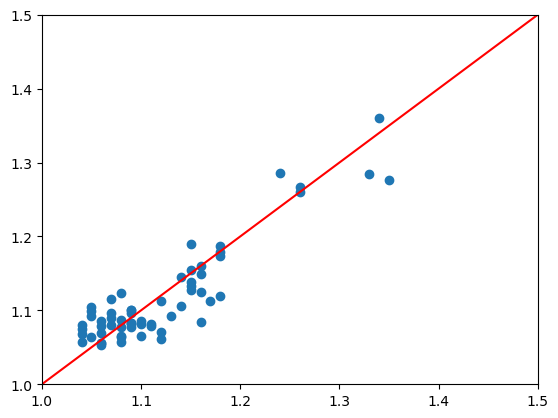

In [43]:
plt.scatter(y_test, y_pred)
plt.ylim(1, 1.5)
plt.xlim(1, 1.5)
x = np.linspace(0,2,20)
y = np.linspace(0,2,20)
plt.plot(x, y, color = 'red')
plt.savefig('../../figures/tti-pred')

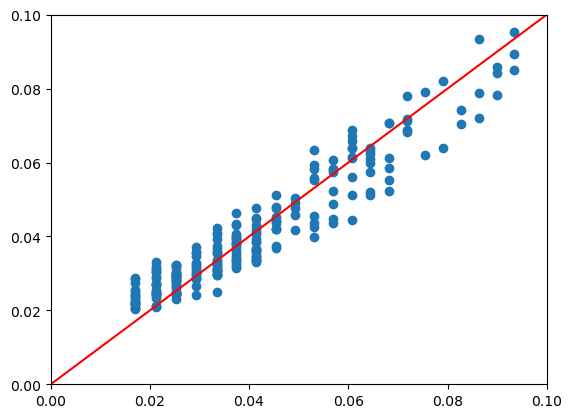

In [23]:
y_pred_train = rf.predict(X_train)
plt.scatter(y_train, y_pred_train)
plt.ylim(0, .1)
plt.xlim(0, .1)
x = np.linspace(0,2,20)
y = np.linspace(0,2,20)
plt.plot(x, y, color = 'red')

In [44]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
tree_importances = pd.Series(result.importances_mean, index=X.columns)

PermissionError: [WinError 5] Access is denied

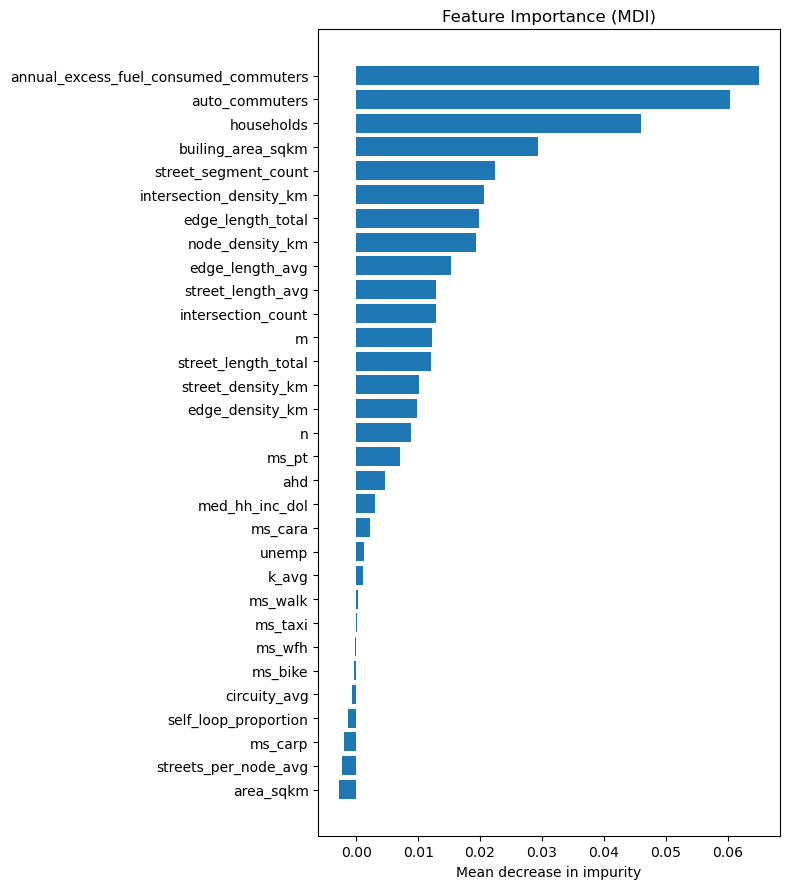

In [45]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

plt.figure(figsize=(8,9))
# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");
plt.tight_layout()
plt.savefig('../../figures/tti-rf.png',dpi=300)

In [26]:
rfc = RandomForestRegressor(max_features= 'log2', n_estimators=700, random_state=0, max_depth = 4 ) #ccp_alpha=0.1
A = df.drop(columns=['ahd', 'log_tti'])
B = (df['ahd'])
A_train, A_test, b_train, b_test = train_test_split(A, B, test_size = .2, random_state = 1)
rfc.fit(A_train, b_train)
b_pred = rfc.predict(A_test)
b_pred

array([  2956.54426241,   2687.73101794,   2652.18075026,   2850.89887645,
        11193.24438661,   3501.63146418,   2964.60340275,  28789.59200594,
         2673.20599916,   6034.3353726 ,   7028.52294756,   2681.27518496,
         4912.30799101,   4283.33787763,   3773.79099839,  75207.43671486,
         2657.3338001 ,   2668.71875773,   4921.17455639,  26385.82575892,
         7887.32357374,   2780.99208328, 255856.22160463,  11513.35619308,
        15247.10519192,   2714.22323971, 119858.00699029,   2679.11575283,
         2782.29814227,   4552.40330852, 541997.72143723,   2745.13122662,
        35772.35362386,  13752.86395446,   2730.21459863,   3628.55008918,
         3088.73492581,   2680.77743547,   2957.40848266,   3075.96961427,
         2666.52378081,   3029.72544324,   7649.70967731,   2733.33976476,
         2865.12946903,   8054.08518101,   3375.28717782,   2729.71582441,
        22387.77429317,   4688.67565329,  12639.94908463,   2795.70357391,
         2692.97747233,  

In [27]:
mse = mean_squared_error(b_test, b_pred)
mape = mean_absolute_percentage_error(b_test, b_pred)
rmse = np.sqrt(mean_squared_error(b_test, b_pred))
print(f'mse = {mse} mape = {mape} rmse = {rmse}')

mse = 806535714.2431747 mape = 0.794391619751416 rmse = 28399.572430640124


In [ ]:
param_grid = { 
    'n_estimators': [100, 200,300, 400, 500, 600, 700],
    'max_features': [3, 5, 9, 12, 'sqrt', 'log2'],
    'max_depth' : [2, 3, 4,5,6,7,8, 9, 10, 11],   
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(A_train, b_train)
CV_rfc.best_params_

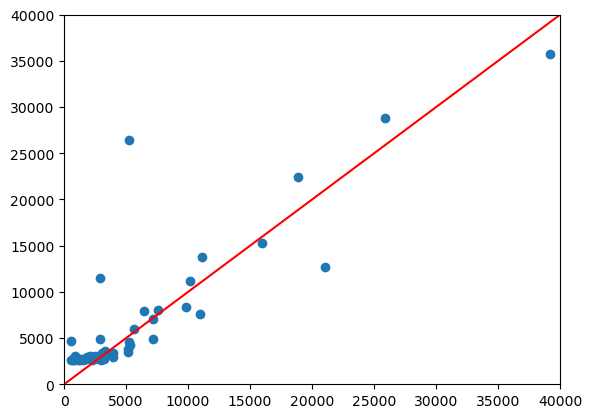

In [29]:
plt.scatter(b_test, b_pred)
plt.ylim(0,40000)
plt.xlim(0, 40000)
x = np.linspace(0,40000,20)
y = np.linspace(0,40000,20)
plt.plot(x, y, color = 'red')
plt.savefig('../../figures/ahd_pred')

In [30]:
result = permutation_importance(
    rfc, A_test, b_test, n_repeats=10, random_state=42, n_jobs=2)
tree_importances = pd.Series(result.importances_mean, index=X.columns)

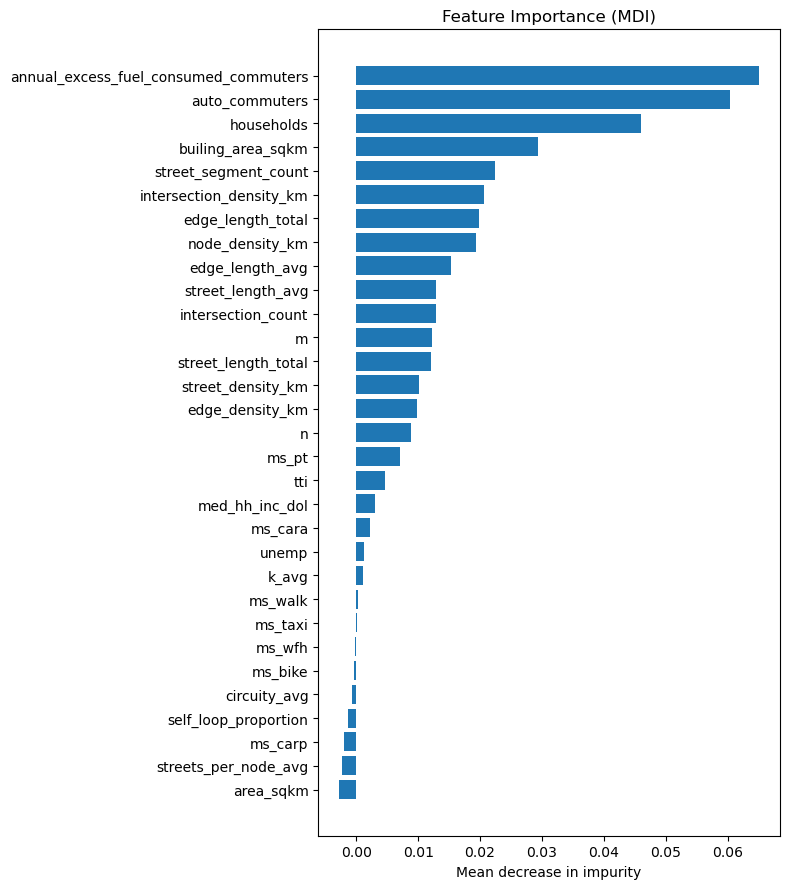

In [33]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances)
pos = np.arange(sorted_idx.shape[0])

plt.figure(figsize=(8,9))
# plot feature importances
plt.barh(pos, tree_importances[sorted_idx], align="center")

plt.yticks(pos, np.array(A.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");
plt.tight_layout()
plt.savefig('../../figures/ahd-rf.png',dpi=300)

In [32]:
A

,auto_commuters,annual_excess_fuel_consumed_commuters,tti,n,m,k_avg,edge_length_total,edge_length_avg,streets_per_node_avg,intersection_count,...,ms_cara,ms_carp,ms_pt,ms_taxi,ms_bike,ms_walk,ms_wfh,unemp,households,med_hh_inc_dol
msa,,,,,,,,,,,,,,,,,,,,,
"Abilene, TX",62,788,1.06,14357,39401,5.488751,1.716897e+07,435.749497,2.881452,11912,...,0.806459,0.117276,0.006420,0.017641,0.002089,0.024034,0.026081,6.4,60343,44249
"Akron, OH",298,6453,1.11,26865,70900,5.278243,1.519199e+07,214.273426,2.756896,21200,...,0.862746,0.066992,0.014979,0.005027,0.001327,0.016849,0.032080,9.7,281752,50776
"Albany, GA",53,810,1.07,8466,22838,5.395228,9.545102e+06,417.948256,2.837468,6957,...,0.804208,0.123413,0.010765,0.007939,0.001490,0.019618,0.032567,15.0,58250,36805
"Albany-Schenectady-Troy, NY",300,5172,1.14,36977,96867,5.239311,2.787244e+07,287.739291,2.755794,30254,...,0.804724,0.076936,0.032160,0.009713,0.002339,0.036837,0.037290,7.4,347401,61841
"Albuquerque, NM",380,8950,1.15,56267,139711,4.966001,4.185019e+07,299.548265,2.720333,43144,...,0.799726,0.095175,0.018131,0.013973,0.009816,0.018735,0.044445,9.1,344168,48875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Yakima, WA",76,1180,1.09,10920,28902,5.293407,1.415503e+07,489.759424,2.709982,8275,...,0.790040,0.135433,0.009615,0.011341,0.002054,0.017380,0.034137,10.0,79717,43956
"York-Hanover, PA",49,227,1.12,16622,44476,5.351462,1.329126e+07,298.841079,2.781194,13507,...,0.848466,0.078800,0.008250,0.009867,0.002737,0.019114,0.032767,8.3,168278,58906
"Youngstown-Warren-Boardman, OH-PA",217,3121,1.05,24885,66650,5.356641,1.973854e+07,296.152150,2.794736,19982,...,0.861136,0.073528,0.007002,0.009999,0.001090,0.016826,0.030420,9.4,230317,42543
